In this notebook we will work through a representational similarity analysis of the Haxby dataset.

In [8]:
import numpy
import nibabel
import os
from haxby_data import HaxbyData
from nilearn.input_data import NiftiMasker
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.manifold
import scipy.cluster.hierarchy

datadir='/home/vagrant/nilearn_data/haxby2001/subj1'

print('Using data from %s'%datadir)

haxbydata=HaxbyData(datadir)

modeldir=os.path.join(datadir,'blockmodel')
try:
    os.chdir(modeldir)
except:
    print('problem changing to %s'%modeldir)
    print('you may need to run the Classification Analysis script first')
    


Using data from /home/vagrant/nilearn_data/haxby2001/subj1


In [9]:
use_whole_brain=False

if use_whole_brain:
    maskimg=haxbydata.brainmaskfile
else:
    maskimg=haxbydata.vtmaskfile
    
nifti_masker = NiftiMasker(mask_img=maskimg, standardize=False)
fmri_masked = nifti_masker.fit_transform(os.path.join(modeldir,'zstatdata.nii.gz'))


Let's ask the following question: Are cats (condition 3) more similar to human faces (condition 2) than to chairs (condition 8)?  To do this, we compute the between-run similarity for all conditions against each other.

In [10]:
cc=numpy.zeros((8,8,12,12))

# loop through conditions
for ci in range(8):
    for cj in range(8):
        for i in range(12):
            for j in range(12):
                idx_i=numpy.where(numpy.logical_and(haxbydata.runs==i,haxbydata.condnums==ci+1))[0][0]
                idx_j=numpy.where(numpy.logical_and(haxbydata.runs==j,haxbydata.condnums==cj+1))[0][0]
                cc[ci,cj,i,j]=numpy.corrcoef(fmri_masked[idx_i,:],fmri_masked[idx_j,:])[0,1]

meansim=numpy.zeros((8,8))
for ci in range(8):
    for cj in range(8):
        cci=cc[ci,cj,:,:]
        meansim[ci,cj]=numpy.mean(numpy.hstack((cci[numpy.triu_indices(12,1)],
                                            cci[numpy.tril_indices(12,1)])))


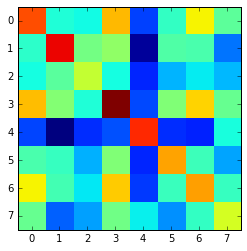

In [11]:
plt.imshow(meansim,interpolation='nearest')


In [12]:
l=scipy.cluster.hierarchy.ward(1.0 - meansim)

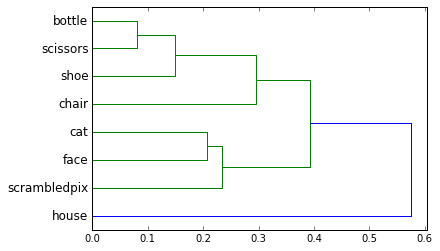

In [13]:
cl=scipy.cluster.hierarchy.dendrogram(l,labels=haxbydata.condlabels,orientation='right')


Let's test whether similarity is higher for faces across runs within-condition versus similarity between faces and all other categories. Note that we would generally want to compute this for each subject and do statistics on the means across subjects, rather than computing the statistics within-subject as we do below (which treats subject as a fixed effect)

In [14]:
# within-condition

face_corr={}
corr_means=[]
corr_stderr=[]
corr_stimtype=[]
for k in haxbydata.cond_dict.keys():
    face_corr[k]=[]
    for i in range(12):
        for j in range(12):
            if i==j:
                continue
            face_corr[k].append(cc[haxbydata.cond_dict['face']-1,haxbydata.cond_dict[k]-1,i,j])

    corr_means.append(numpy.mean(face_corr[k]))
    corr_stderr.append(numpy.std(face_corr[k])/numpy.sqrt(len(face_corr[k])))
    corr_stimtype.append(k)

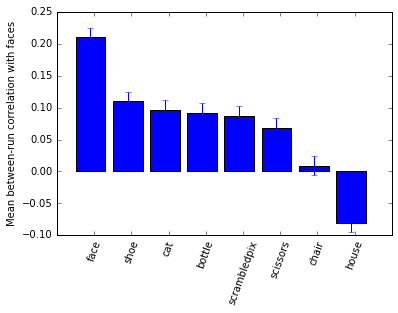

In [15]:
idx=numpy.argsort(corr_means)[::-1]
plt.bar(numpy.arange(0.5,8.),[corr_means[i] for i in idx],yerr=[corr_stderr[i] for i in idx]) #,yerr=corr_sterr[idx])
t=plt.xticks(numpy.arange(1,9), [corr_stimtype[i] for i in idx],rotation=70)
plt.ylabel('Mean between-run correlation with faces')

In [16]:
import sklearn.manifold
mds=sklearn.manifold.MDS()
#mds=sklearn.manifold.TSNE(early_exaggeration=10,perplexity=70,learning_rate=100,n_iter=5000)
encoding=mds.fit_transform(fmri_masked)

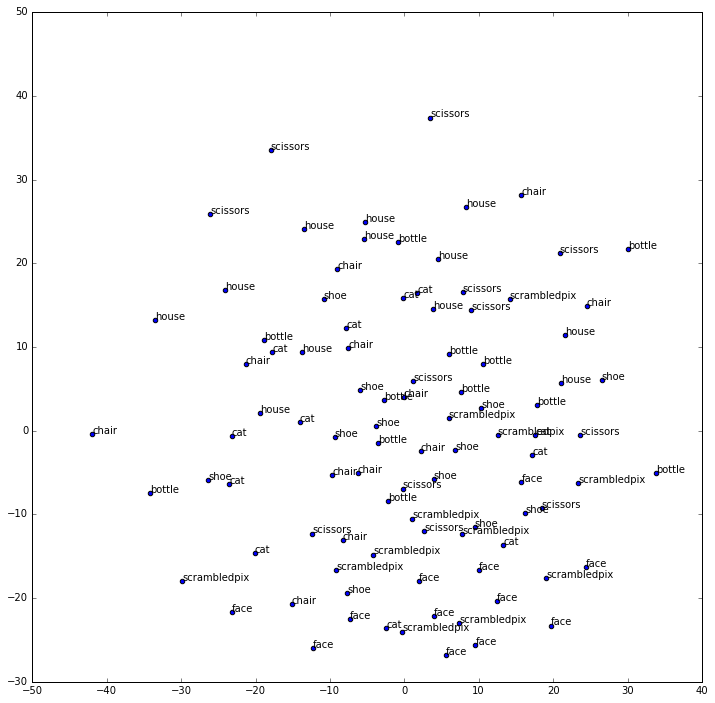

In [17]:
plt.figure(figsize=(12,12))
ax=plt.axes() #[numpy.min(encoding[0]),numpy.max(encoding[0]),numpy.min(encoding[1]),numpy.max(encoding[1])])
ax.scatter(encoding[:,0],encoding[:,1])
offset=0.01
for i in range(encoding.shape[0]):
    ax.annotate(haxbydata.conditions[i].split('-')[0],(encoding[i,0],encoding[i,1]),xytext=[encoding[i,0]+offset,encoding[i,1]+offset])
#for i in range(encoding.shape[0]):
#    plt.text(encoding[i,0],encoding[i,1],'%d'%haxbydata.condnums[i])


In [18]:
mdsmeans=numpy.zeros((2,8))
for i in range(8):
    mdsmeans[:,i]=numpy.mean(encoding[haxbydata.condnums==(i+1),:],0)

In [19]:
for i in range(2):
    print('Dimension %d:'%int(i+1))
    idx=numpy.argsort(mdsmeans[i,:])
    for j in idx:
        print('%s:\t%f'%(haxbydata.condlabels[j],mdsmeans[i,j]))
    print('')



Dimension 1:
chair:	-6.410863
cat:	-4.931889
house:	-4.641099
shoe:	0.781487
scissors:	2.538163
bottle:	3.643795
scrambledpix:	3.984824
face:	5.035580

Dimension 2:
face:	-20.440576
scrambledpix:	-10.521346
shoe:	-2.140139
cat:	-0.596725
chair:	3.082294
bottle:	5.077130
scissors:	9.503924
house:	16.035438

